# This notebook contains code to map the locations of NP, Sheba, MOSAiC and AMSR-Ice snow depth transects

In [228]:
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy
import datetime
import matplotlib.pyplot as plt
from ll_xy import lonlat_to_xy
import tqdm
import pickle
from netCDF4 import Dataset
import os

# Get SHEBA track

In [229]:
d = Dataset('../evaluation_data/SHEBA_transects/SHEBA_track.nc')


df_dict = {

'lons' : np.array(d['longitude']),
'lats' : np.array(d['latitude']),
'days' : np.array(d['Jdd']),

}

df = pd.DataFrame(df_dict)

df = df[df['lons']<400]


df['dt'] = [datetime.datetime(1997,1,1) + datetime.timedelta(days=jd) for jd in df['days']]

df.set_index(['dt'],inplace=True)

dfD = df.resample('D').mean()

dfi = dfD.interpolate(method='linear')

# Get SHEBA transect dates

In [230]:
Adf = pd.read_excel('../evaluation_data/SHEBA_transects/SHEBAsnowNCAR.xls', sheet_name='Atlanta')
Tdf = pd.read_excel('../evaluation_data/SHEBA_transects/SHEBAsnowNCAR.xls', sheet_name='Tuk')

Adts = [x for x in Adf.iloc[5] if type(x) == datetime.datetime]
Tdts = [x for x in Tdf.iloc[5] if type(x) == datetime.datetime]

SHEBA_dts = list(set(Adts + Tdts))

dfi['valid'] = [True if i.to_pydatetime() in SHEBA_dts else False
                for i in dfi.index]

sheba_df_valid = dfi[dfi['valid'] == True]

# Plot the days on which transects were done

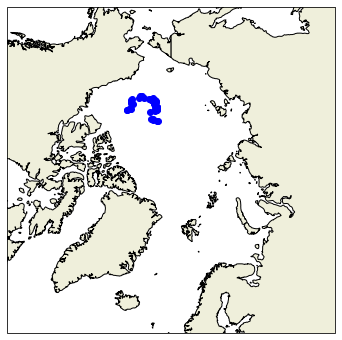

In [231]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=0)

ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

ax.scatter(sheba_df_valid['lons'],
           sheba_df_valid['lats'],
           transform=ccrs.PlateCarree(),
           zorder=5,
           color='b')

# Get AMSR-Ice Coordinates

In [232]:
beaufort_lon = -156.34
beaufort_lat = 71.38

chukchi_lon = -156.53
chukchi_lat = 71.36

elson_lon = -156.55374
elson_lat = 71.30936

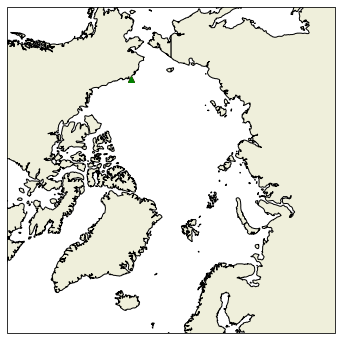

In [233]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=0)

ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

ax.scatter(elson_lon,
           elson_lat,
           transform=ccrs.PlateCarree(),
           zorder=1,
           marker='^',
           color='b')

ax.scatter(chukchi_lon,
           chukchi_lat,
           transform=ccrs.PlateCarree(),
           zorder=1,
           marker='^',
           color='r')

ax.scatter(beaufort_lon,
           beaufort_lat,
           transform=ccrs.PlateCarree(),
           zorder=1,
           marker='^',
           color='g')

# Get MOSAiC Coordinates

In [234]:
paths = pickle.load(open('../pickles/valid_nloops.p','rb'))

runway_paths = ['/home/robbie/Dropbox/sub_km/evaluation_data/MOSAiC_transects/mcs_polona/02-snow-depth/PS122-2_19-139/magna+gem2-transect-20200112_PS122-2_19-139_runway.csv',
                '/home/robbie/Dropbox/sub_km/evaluation_data/MOSAiC_transects/mcs_polona/02-snow-depth/PS122-2_20-124/magna+gem2-transect-20200119_PS122-2_20-124_runway.csv',
               '/home/robbie/Dropbox/sub_km/evaluation_data/MOSAiC_transects/mcs_polona/02-snow-depth/PS122-2_23-90/magna+gem2-transect-20200207_PS122-2_23-90_runway.csv',
               ]

paths = paths + runway_paths

In [235]:
mosaic_lons = []
mosaic_lats = []

for path in paths:
   
    df = pd.read_csv(path)
    
    l1 = df.iloc[0]
    
    mosaic_lons.append( l1[1] )
    mosaic_lats.append( l1[2] )
    

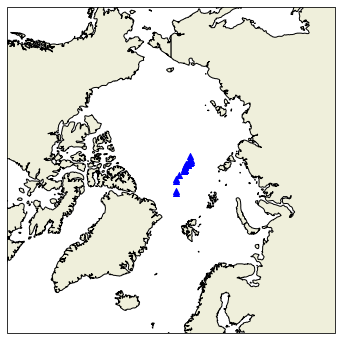

In [236]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=0)

ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

ax.scatter(mosaic_lons,
           mosaic_lats,
           transform=ccrs.PlateCarree(),
           zorder=1,
           marker='^',
           color='b')

# Get NP Transect Coordinates

In [237]:
position_dir = '../NP_positions'
position_dir = '/home/robbie/Dropbox/SP_W99_Drifters/Data/W99_clean/MET'
dfs = {}

for file in tqdm.tqdm(os.listdir(position_dir)):
    
    fname = file.split('.')[0]
    station = int(fname.split('_')[-1])



    df = pd.read_csv(f'{position_dir}/{file}',delim_whitespace=True)

    df.columns = ['station','y','m','d','h','lat','lon',
                      'x0','x1','x2','x3','x4','x5','x6','x7']
    
    df['year'] = 1900+df['y']

    df['x'], df['y'] = lonlat_to_xy(np.array(df['lon']),
                                    np.array(df['lat']),
                                    hemisphere='n')


    df['h'] = [h if h<24 else 0 for h in df['h']]

    df['dt'] = [datetime.datetime(y,m,d,h) for (y,m,d,h) in zip(df['year'],df['m'],df['d'],df['h'])]

    df.set_index('dt',inplace=True)

    df = df[['x','y']]

    df = df.resample('D').mean()

    df.interpolate(method='linear',axis=0,inplace=True)

    df['longitude'], df['latitude'] = lonlat_to_xy(np.array(df['x']),
                                                   np.array(df['y']),
                                                   inverse=True,
                                                   hemisphere='n')

    dfs[station] = df

100%|███████████████████████████████████████████| 31/31 [00:02<00:00, 13.17it/s]


# Now get dates of transects

In [238]:
np_dates = pickle.load(open('../evaluation_data/dates.p','rb'))

np_trans_lons = []
np_trans_lats = []

for station, date in np_dates:
    
    df = dfs[station]
    
    try:
        ind = [idx for idx, element in enumerate(df.index) if element.to_pydatetime().date() == date][0]
    
        np_trans_lons.append( df.iloc[ind][2] )
        np_trans_lats.append( df.iloc[ind][3] )
        
    except Exception as e:
        
        print(station, e)

27 list index out of range
29 list index out of range
29 list index out of range
24 list index out of range
30 list index out of range
9 list index out of range
9 list index out of range
9 list index out of range
9 list index out of range
9 list index out of range


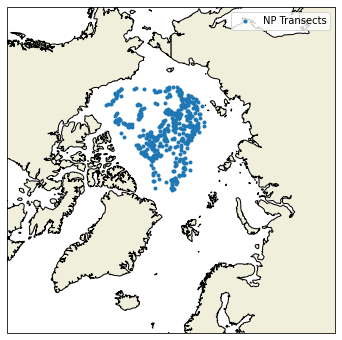

In [239]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=0)

ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

ax.scatter(np_trans_lons,
           np_trans_lats,
           transform=ccrs.PlateCarree(),
           zorder=1,
           marker='.',
           label='NP Transects')
    
ax.legend(ncol=2)

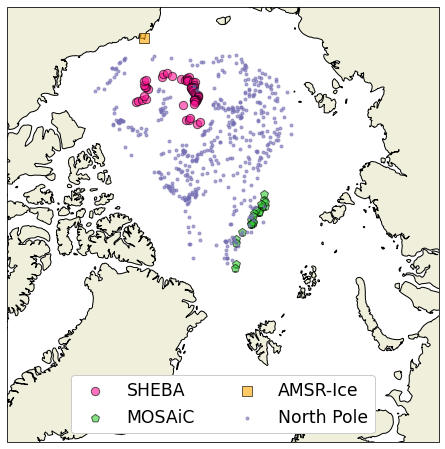

In [241]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=0)

ax.set_extent([-180, 180, 90, 70], ccrs.PlateCarree())


ax.scatter(sheba_df_valid['lons'],
           sheba_df_valid['lats'],
           transform=ccrs.PlateCarree(),
           zorder=5,
           edgecolors='k',
           alpha=0.6,
           s=70,
           label='SHEBA',
           color='deeppink')

ax.scatter(mosaic_lons,
           mosaic_lats,
           transform=ccrs.PlateCarree(),
           zorder=1,
           marker='p',
           s=70,
           label='MOSAiC',
           alpha=0.6,
           edgecolors='k',
           color='limegreen')

ax.scatter(elson_lon,
           elson_lat,
           edgecolors='k',
           transform=ccrs.PlateCarree(),
           zorder=1,
           marker='s',
           s=100,
           alpha=0.6,
           label='AMSR-Ice',
           color='orange')

ax.scatter(np_trans_lons,
           np_trans_lats,
           transform=ccrs.PlateCarree(),
           zorder=10,
           marker='.',
           alpha=0.6,
           color='#7570b3',
           label='North Pole')
    
legend = ax.legend(ncol=2,loc='lower center',fontsize='xx-large',facecolor='white', framealpha=1)

plt.savefig('../figures/fig_1.png', bbox_inches='tight',dpi=500)    
plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/figs/fig1.png', bbox_inches='tight',dpi=500)    

In [211]:
len(sheba_df_valid)

56